In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import curve_fit


import math
from skimage import color
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import skimage.draw as sdraw
from skimage.util import img_as_ubyte

from skimage.morphology import binary_closing, disk, erosion, dilation
import scipy.ndimage as nd
import skimage.draw as sdraw

from matplotlib import colors
from skimage.measure import label, regionprops

In [15]:
# #6ms 20FA
# DICOM1 = 'NPERIODIC_140423_1.MR.0003.0001.2023.04.14.15.23.33.996403.63216740.IMA'
# DICOM2 = 'NPERIODIC_140423_1.MR.0003.0002.2023.04.14.15.23.33.996403.63216758.IMA'
# DICOM3 = 'NPERIODIC_140423_1.MR.0003.0003.2023.04.14.15.23.33.996403.63216776.IMA'
# DICOM4 = 'NPERIODIC_140423_1.MR.0003.0004.2023.04.14.15.23.33.996403.63216794.IMA'
# DICOM5 = 'NPERIODIC_140423_1.MR.0003.0005.2023.04.14.15.23.33.996403.63216812.IMA'
# DICOM6 = 'NPERIODIC_140423_1.MR.0003.0006.2023.04.14.15.23.33.996403.63216830.IMA'
# DICOM7 = 'NPERIODIC_140423_1.MR.0003.0007.2023.04.14.15.23.33.996403.63216848.IMA'
# DICOM8 = 'NPERIODIC_140423_1.MR.0003.0008.2023.04.14.15.23.33.996403.63216866.IMA'
# DICOM9 = 'NPERIODIC_140423_1.MR.0003.0009.2023.04.14.15.23.33.996403.63216884.IMA'
# DICOM10 = 'NPERIODIC_140423_1.MR.0003.0010.2023.04.14.15.23.33.996403.63216902.IMA'
# DICOM11 = 'NPERIODIC_140423_1.MR.0003.0011.2023.04.14.15.23.33.996403.63216920.IMA'
# DICOM12 = 'NPERIODIC_140423_1.MR.0003.0012.2023.04.14.15.23.33.996403.63216938.IMA'
# DICOMFILENAME = [DICOM1,DICOM2,DICOM3,DICOM4,DICOM5,DICOM6,DICOM7,DICOM8,DICOM9,DICOM10,DICOM11,DICOM12]

In [355]:
LastCODE = 63238286
specialCODE = '0031'
fa = 90
tr = 8
TR = 8e-3
TE = TR/2 

DICOMFILENAME = []
for i in range (0,10):
    LAST = str(LastCODE+18*i)
    if(i<9):
         DICOM1 = 'DICOM/GOLDSTANDARD_'+str(tr)+'msTR_'+str(fa)+'FA/NPERIODIC_140423_1.MR.'+specialCODE+'.000'+str(int(i+1))+'.2023.04.14.15.23.33.996403.'+LAST+'.IMA'
    else:
        DICOM1 = 'DICOM/GOLDSTANDARD_'+str(tr)+'msTR_'+str(fa)+'FA/NPERIODIC_140423_1.MR.'+specialCODE+'.00'+str(int(i+1))+'.2023.04.14.15.23.33.996403.'+LAST+'.IMA'
    DICOMFILENAME.append(DICOM1)
    print(DICOM1)

DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0001.2023.04.14.15.23.33.996403.63238286.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0002.2023.04.14.15.23.33.996403.63238304.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0003.2023.04.14.15.23.33.996403.63238322.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0004.2023.04.14.15.23.33.996403.63238340.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0005.2023.04.14.15.23.33.996403.63238358.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0006.2023.04.14.15.23.33.996403.63238376.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0007.2023.04.14.15.23.33.996403.63238394.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0008.2023.04.14.15.23.33.996403.63238412.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0009.2023.04.14.15.23.33.996403.63238430.IMA
DICOM/GOLDSTANDARD_8msTR_90FA/NPERIODIC_140423_1.MR.0031.0010.2023.04.14.15.23.33.

In [356]:
#LOAD DICOM DATA
GOLDSTD_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,10):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    GOLDSTD_DATA = np.append(GOLDSTD_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
GOLDSTD_DATA =  np.delete(GOLDSTD_DATA,0,0)
#pixel array for different TR stored in GOLDSTD_DATA



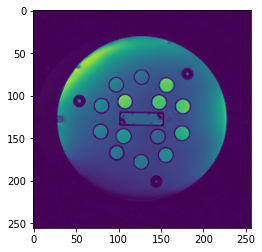

In [296]:
plt.imshow(GOLDSTD_DATA[1,:,:])

<BarContainer object of 10 artists>

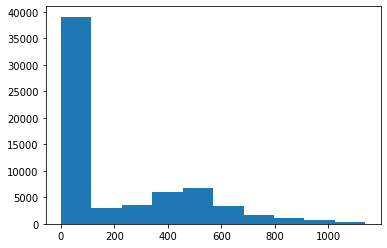

In [252]:
image = GOLDSTD_DATA[2,:,:]
hist, bin_edges = np.histogram(image)
barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
plt.bar(bin_edges[:-1], hist, width=barw, align='edge') 


### Generate MASK

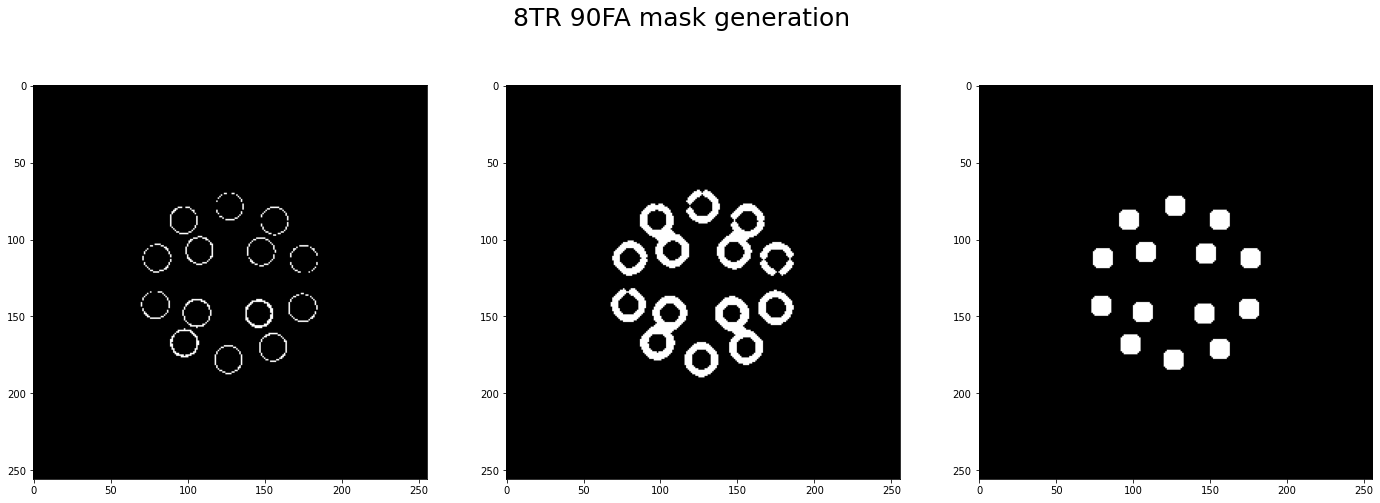

In [257]:
def multi_erosion(image, kernel, iterations):
    for i in range(iterations):
        image = erosion(image, kernel)
    return image

def multi_dilation(image, kernel, iterations):
    for i in range(iterations):
        image = dilation(image, kernel)
    return image
cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])

#MASK generate base on the first image
image = GOLDSTD_DATA[0,:,:]
#Final Mask
MASK = np.zeros((256,256))
fig=plt.figure(figsize=(24, 8))


#STEP 1 Remove quare at middle and other things in the background 
I_pre = np.asarray(np.zeros((256,256)), dtype = float)
for x in range (0,256):
    for y in range (0,256):
        if ((GOLDSTD_DATA[1,x,y]*GOLDSTD_DATA[1,x,y]*GOLDSTD_DATA[1,x,y])<200000):
            I_pre[x,y] = 1
        if ((pow(x-125,2)+pow(y-125,2))>4410):
            I_pre[x,y] = 0
        if (x>117 and x<136 and y>90 and y<155):
            I_pre[x,y] = 0
fig.add_subplot(1,3,1)
plt.imshow(I_pre, cmap='gray')

#STEP 2 Closing the circles 
strel = disk(1)
I_closed = binary_closing(I_pre, strel)
I_closed = multi_dilation(I_closed, cross, 4)
I_closed = multi_erosion(I_closed, cross, 2)
# Closed image
fig.add_subplot(1,3,2)
plt.imshow(I_closed, cmap='gray')

#STEP 3 Draw circle on the final MASK
# skimage version 0.14.0
IMAGE = I_closed

BEST_COUNT = 14              # how many circles to draw
MIN_RADIUS = 7              # min radius should be bigger than noise
MAX_RADIUS = 20             # max radius of circles to be detected (in pixels)
LARGER_THRESH = 1.2         # circle is considered significantly larger than another one if its radius is at least so much bigger
OVERLAP_THRESH = 0.1        # circles are considered overlapping if this part of the smaller circle is overlapping

def circle_overlap_percent(centers_distance, radius1, radius2):
    '''
    Calculating the percentage area overlap between circles
    See Gist for comments:
        https://gist.github.com/amakukha/5019bfd4694304d85c617df0ca123854
    '''
    R, r = max(radius1, radius2), min(radius1, radius2)
    if centers_distance >= R + r:
        return 0.0
    elif R >= centers_distance + r:
        return 1.0
    R2, r2 = R**2, r**2
    x1 = (centers_distance**2 - R2 + r2 )/(2*centers_distance)
    x2 = abs(centers_distance - x1)
    y = math.sqrt(R2 - x1**2)
    a1 = R2 * math.atan2(y, x1) - x1*y
    if x1 <= centers_distance:
        a2 = r2 * math.atan2(y, x2) - x2*y
    else:
        a2 = math.pi * r2 - a2
    overlap_area = a1 + a2
    return overlap_area / (math.pi * r2)

def circle_overlap(c1, c2):
    d = math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)
    return circle_overlap_percent(d, c1[2], c2[2])

def inner_circle(cs, c, thresh):
    '''Is circle `c` is "inside" one of the `cs` circles?'''
    for dc in cs:
        # if new circle is larger than existing -> it's not inside
        if c[2] > dc[2]*LARGER_THRESH: continue
        # if new circle is smaller than existing one...
        if circle_overlap(dc, c)>thresh:
            # ...and there is a significant overlap -> it's inner circle
            return True
    return False

# Load picture and detect edges
image = IMAGE
edges = canny(image, sigma=3)

# Detect circles of specific radii
hough_radii = np.arange(MIN_RADIUS, MAX_RADIUS, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent circles (in order from best to worst)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii)

# Determine BEST_COUNT circles to be drawn
drawn_circles = []
for crcl in zip(cy, cx, radii):
    # Do not draw circles if they are mostly inside better fitting ones
    if not inner_circle(drawn_circles, crcl, OVERLAP_THRESH):
        # A good circle found: exclude smaller circles it covers
        i = 0
        while i<len(drawn_circles):
            if circle_overlap(crcl, drawn_circles[i]) > OVERLAP_THRESH:
                t = drawn_circles.pop(i)
            else:
                i += 1
        # Remember the new circle
        drawn_circles.append(crcl)
    # Stop after have found more circles than needed
    if len(drawn_circles)>BEST_COUNT:
        break

drawn_circles = drawn_circles[:BEST_COUNT]

# Actually draw circles
colors  = [(250, 0, 0), (0, 250, 0), (0, 0, 250)]
colors += [(200, 200, 0), (0, 200, 200), (200, 0, 200)]
#image = color.gray2rgb(image)
for center_y, center_x, radius in drawn_circles:
    circy, circx = sdraw.disk((center_y, center_x), radius)
    #color = colors.pop(0)
    MASK[circy, circx] = 1
    #colors.append(color)

MASK = multi_erosion(MASK, cross, 4)
fig.add_subplot(1,3,3)
plt.imshow(MASK, cmap='gray')
fig.suptitle(str(tr)+"TR "+str(fa)+"FA mask generation", fontsize = 25)
#plt.savefig("Figure/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_MASK_Generate.jpg")

### USE STANDARD MASK

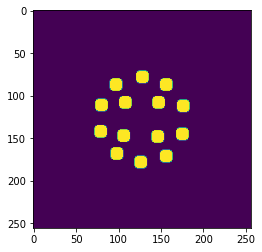

In [289]:
STANDARD_MASK_LABEL = np.load("Figure/GOLDstandardT2Star/STANDARD_MASK.npy")
STANDARD_MASK = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if(STANDARD_MASK_LABEL[i,j]>0):
            STANDARD_MASK[i,j]= 1
            

plt.imshow(STANDARD_MASK)

### Fitting to calculate R2* of the phantom

In [357]:
#R2* Fitting
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
R2StarImage = np.asarray([], dtype = float)
for x in range (0,256):
    for y in range (0,256):
        popt, pcov = curve_fit(func, TIME, GOLDSTD_DATA[:,x,y]*STANDARD_MASK[x,y])
        PixelR2Star = popt[1]
        R2StarImage = np.append(R2StarImage, PixelR2Star)
R2StarImage = R2StarImage.reshape(256,256)



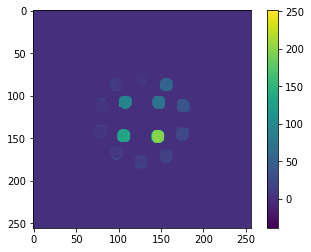

In [358]:
plt.imshow(R2StarImage)
plt.colorbar()

### T2* and Mean T2* value, Standard Deviation of T2* value in each circle

0.24978795101467624
0.08530313362578784
0.09710910206407658
0.02103900645740336
0.017968387055788446
0.0004932095308867425
0.010778543671892314
0.0003530480119827377
0.013936825735676062
0.0004781814861359665
0.16371027976302316
0.01857920616535878
0.028246018454367208
0.0006842779155232454
0.14589861747409702
0.015341322966701775
0.0411113225005262
0.0012319784643640593
0.007575839913489533
0.0002485306734611432
0.005070850061753397
0.00022400962834928257
0.11177440597679299
0.01258167856331987
0.059517395045798636
0.0035451293146994793
0.07603712715510774
0.006066677873377021


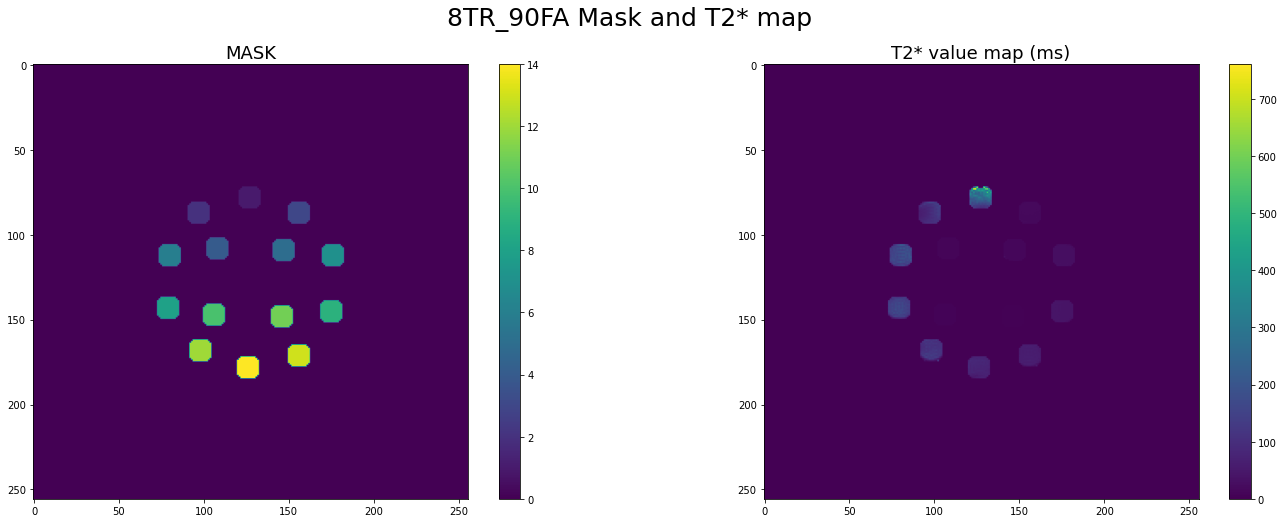

In [359]:
T2SMAP = np.zeros((256,256))
#Label the mask
LABELMASK = label(MASK)

for number in range (1,15):
    T2StarMeasured = np.asarray([], dtype = float)
    
    #Generate mask of one circle
    CircleMASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(LABELMASK[i,j]==number):
                CircleMASK[i,j] = 1

    #Only the R2* values of that circle remain
    R2MAP1 = R2StarImage*CircleMASK

    for i in range (0,256):
        for j in range (0,256):
            if(R2MAP1[i,j] > 1):
                T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                #store T2*value in the T2* Map
                T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms

              
    #remove outliers and calcuate mean
    mean = np.mean(T2StarMeasured, axis=0)
    sd = np.std(T2StarMeasured, axis=0)

    final_list = [x for x in T2StarMeasured if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
    # print("Phantom Circle "+str(number))
    # print("Mean: "+ str(np.mean(final_list)))
    # print("SD: "+ str(np.std(final_list)))
    print(np.mean(final_list))
    print(np.std(final_list))
    
T2Sfig = plt.figure(figsize=(24, 8))  
T2Sfig.add_subplot(121)
plt.imshow(LABELMASK)
plt.colorbar()
plt.title("MASK", fontsize = 18)

T2Sfig.add_subplot(122)
plt.imshow(T2SMAP)
plt.colorbar()
plt.title("T2* value map (ms)", fontsize = 18)

T2Sfig.suptitle(str(tr)+"TR_"+str(fa)+"FA Mask and T2* map", fontsize = 25)
#plt.savefig("Figure/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.jpg")

In [360]:
#np.save("Figure/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2StarMAP.npy", T2SMAP)
# np.save("Figure/GOLDstandardT2Star/"+str(tr)+"TR_"+str(fa)+"FA_T2MASK.npy", LABELMASK)

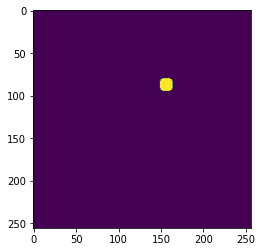

In [361]:
MASK_parts = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if (STANDARD_MASK_LABEL[i,j]==3):
            MASK_parts[i,j]=1
plt.imshow(MASK_parts)